### Informações sobre atributos:
1) __id__: identificador único
2) __gênero__: "Masculino", "Feminino" ou "Outro"
3) __idade__: idade do paciente
4) __hipertensão__: 0 se o paciente não tiver hipertensão, 1 se o paciente tiver hipertensão
5) __doença cardíaca__: 0 se o paciente não tiver doença cardíaca, 1 se o paciente tiver doença cardíaca
6) __já casado__: "Não" ou "Sim"
7) __tipo de trabalho__: "crianças"(`children`), "Funcionário público"(`Govt_jov`), "Nunca trabalhou"(`Never_worked`), "Privado"(`Private`) ou "Autônomo"(`Self-employed`)
8) __tipo de residência__: "Rural" ou "Urbana"
9) __nível médio de glicose__: nível médio de glicose no sangue
10) __IMC__: índice de massa corporal
11) __status de tabagismo__: "ex-fumante"(`formerly smoked`), "nunca fumou"(`formerly smoked`), "fuma"(`smokes`) ou "Desconhecido"(`Unknown`)
12) __AVC__: 1 se o paciente teve um AVC ou 0 se não teve

In [149]:
import copy 
import scipy
import warnings
import pandas as pd
import numpy as np
import seaborn as sea 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [150]:
warnings.filterwarnings('ignore',category=FutureWarning)

In [151]:
data = pd.read_csv(r'datasets/StrokePredictionDataset/healthcare-dataset-stroke-data.csv',sep=',')

In [152]:
data.head(4)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


## Analise dos dados

In [153]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


> Nesse conjunto de daddos para valores númericos continuos irei fazer a padronização dos dados

In [154]:
data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

> quantidade de valores unicos de cada atributo

In [155]:
valoresNulos = (pd.concat([data.isna().nunique(),data.isnull().nunique()] ,axis=1))
valoresNulos.columns = ['NaN','NULL']
valoresNulos

,NaN,NULL
id,1,1
gender,1,1
age,1,1
hypertension,1,1
heart_disease,1,1
ever_married,1,1
work_type,1,1
Residence_type,1,1
avg_glucose_level,1,1
bmi,2,2


In [156]:
data.loc[data['bmi'].isna()==True]['stroke'].value_counts()

stroke
0    161
1     40
Name: count, dtype: int64

In [157]:
data.drop(index = data.loc[data['bmi'].isna()==True].index , inplace=True)

> Será removido para a analises depois decido oq fazer com esses valores nulos

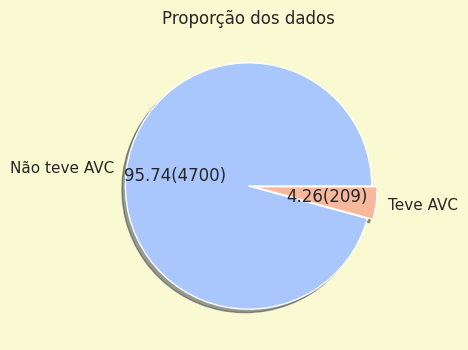

In [158]:
pizza = data['stroke'].value_counts()

plt.figure(figsize=(6,4),facecolor='#FAFAD2')
plt.pie(x=pizza.values , labels= ['Não teve AVC','Teve AVC'] , autopct = lambda x:'{:.2f}({:.0f})'.format(x,((x*pizza.sum())/100)) , colors=sea.color_palette('coolwarm',n_colors=2),shadow=True,explode=(0,0.045),pctdistance=0.6)
plt.title('Proporção dos dados')
plt.show()

> No preprocessamento dos dados para a classificação se faz necessario o balanceamento dos dados , a mais valores para pessoas que não teve Avc para as que tiveram

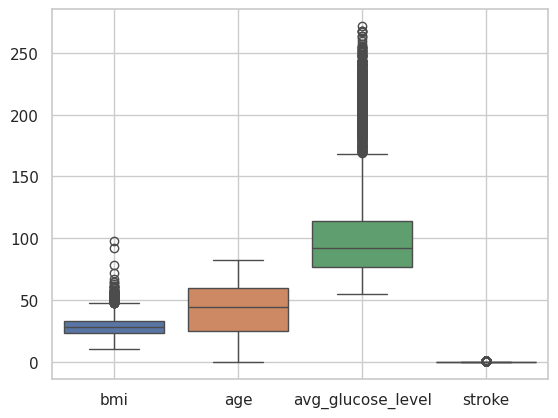

In [159]:
sea.boxplot( data[['bmi','age','avg_glucose_level','stroke']])
plt.grid(True)
plt.show()

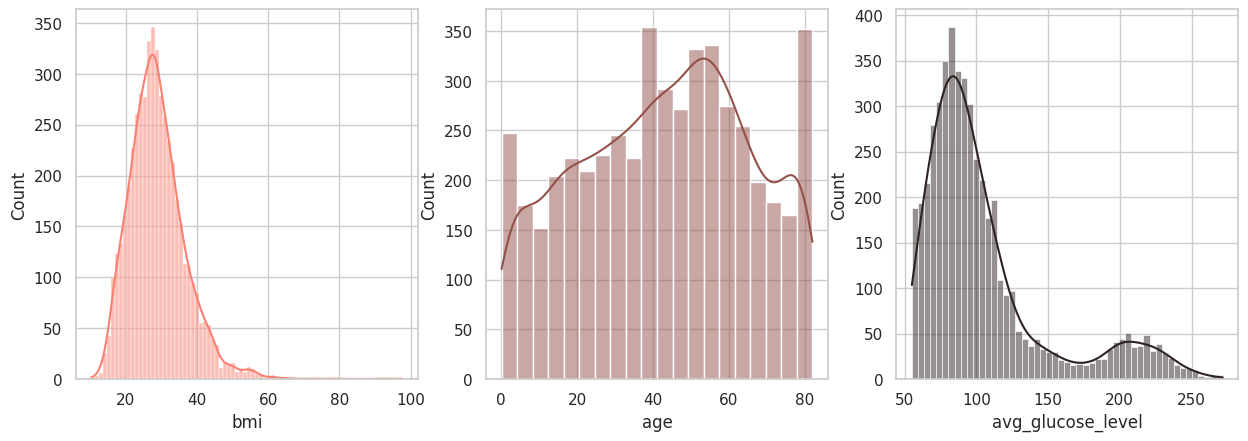

In [160]:
fig , ax = plt.subplots(1,3)
fig.set_figwidth(15)
colors   = sea.color_palette('dark:salmon_r',n_colors=3)
index    = 0
for coluna in ['bmi','age','avg_glucose_level']:
    sea.histplot(data[coluna], ax=ax[index] ,color=colors[index] , kde=True); index +=1
plt.show()

> Há outlier

In [161]:
bin   = [min(data['bmi']),18.5,24.9,29.9,max(data['bmi'])]
label = ['abaixo do peso','peso ideal','acima do peso','obesidade']
freq  = pd.cut(x = data['bmi'] , bins=bin ,labels=label)
hist  = pd.concat([freq,data[['stroke']]],axis=1)
hist  = hist.groupby(by=['bmi'])['stroke'].value_counts().reset_index()

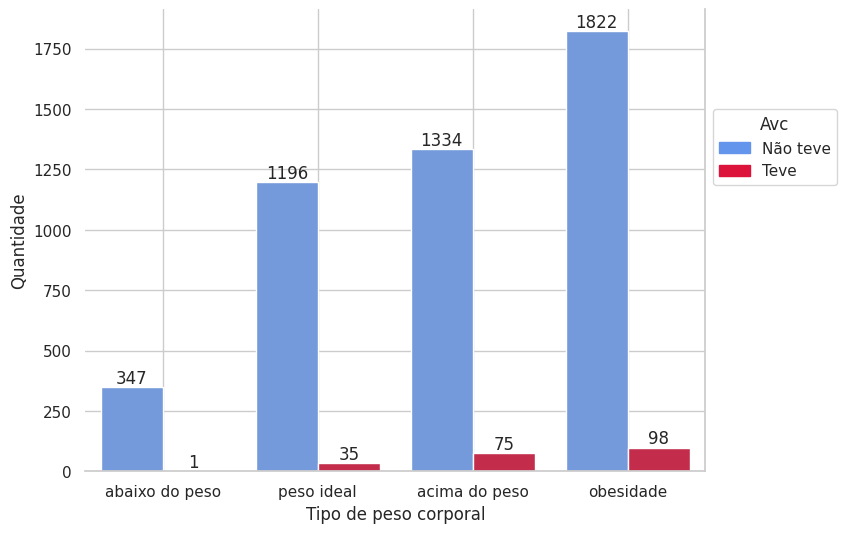

In [162]:
fig ,ax = plt.subplots(1,1)
fig.set_figwidth(8)
fig.set_figheight(6)

colors  = ['#6495ED','#DC143C'] 
bar = sea.barplot(x = hist['bmi'] ,y=hist['count'],hue=hist['stroke'],palette=colors ,ax=ax)
bar.bar_label( bar.containers[0] )
bar.bar_label( bar.containers[1] )

ax.set_ylabel('Quantidade')
ax.set_xlabel('Tipo de peso corporal')
ax.spines[['top','left']].set_visible(False)
legends = []
for value, color in zip(['Não teve','Teve'], colors): legends.append(mpatches.Patch(color=color, label=value))

ax.legend(title='Avc',handles=legends,bbox_to_anchor=(1,0.8,0,0))
plt.grid(True)
plt.show()

In [163]:
data['gender'].value_counts().reset_index()

,gender,count
0,Female,2897
1,Male,2011
2,Other,1


In [164]:
data.drop( index = data.loc[data['gender']=='Other'].index , inplace=True)

> No atributo `gender` o valores other só aparece uma vez , será removido

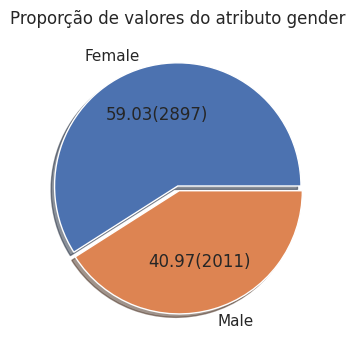

In [165]:
pizza = data['gender'].value_counts()

plt.figure(figsize=(6,4))
plt.pie(x = pizza.values , labels = pizza.index , explode=(0,0.04),autopct=lambda x: '{:.2f}({:.0f})'.format(x,((x*sum(pizza.values))/100)) , shadow=True)
plt.title('Proporção de valores do atributo gender')
plt.show()

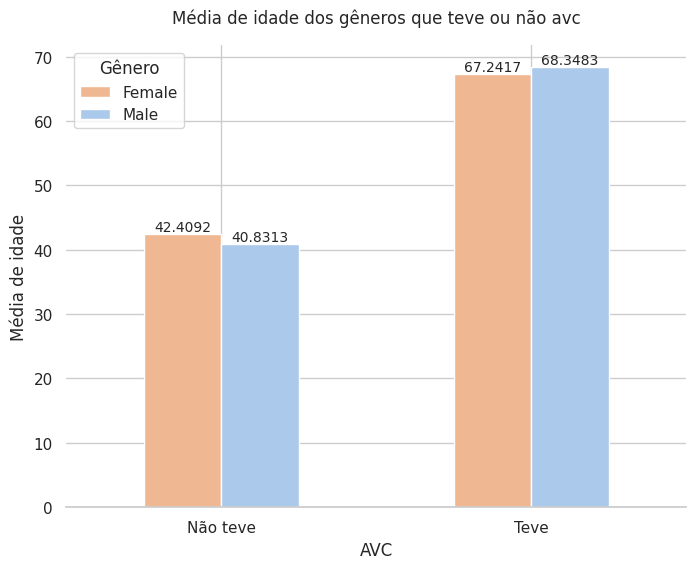

In [173]:
resultado = data.groupby(by=['gender','stroke'])['age'].mean().reset_index()

fig , ax = plt.subplots(1,1)
fig.set_figwidth(8)
fig.set_figheight(6)

bar = sea.barplot(x = resultado['stroke'] , y=resultado['age'] ,hue = resultado['gender'],palette=sea.color_palette('pastel')[0:2][::-1],width=0.5,ax=ax)
bar.bar_label(bar.containers[0], fontsize=10)
bar.bar_label(bar.containers[1], fontsize=10)

ax.set_axisbelow(True)
ax.grid(axis='x')
ax.spines[['right','top','left']].set_visible(False)
plt.legend(title='Gênero')
plt.title('Média de idade dos gêneros que teve ou não avc',y=1.029)
plt.xticks([0,1],['Não teve','Teve'])
plt.ylabel('Média de idade')
plt.xlabel('AVC')

plt.show()

In [167]:
bin   = [ min(data['bmi']),18.5,24.9,29.9,max(data['bmi']) ]
label = ['Abaixo do peso','Peso ideal','Acima do peso','Obesidade']
freq  = pd.cut(x = data['bmi'] , bins=bin ,labels=label)

resultado = pd.concat([freq,data[['work_type','stroke']]],axis=1)

In [168]:
gropbyresultado = resultado.groupby(by=['work_type'])['bmi'].value_counts().reset_index()

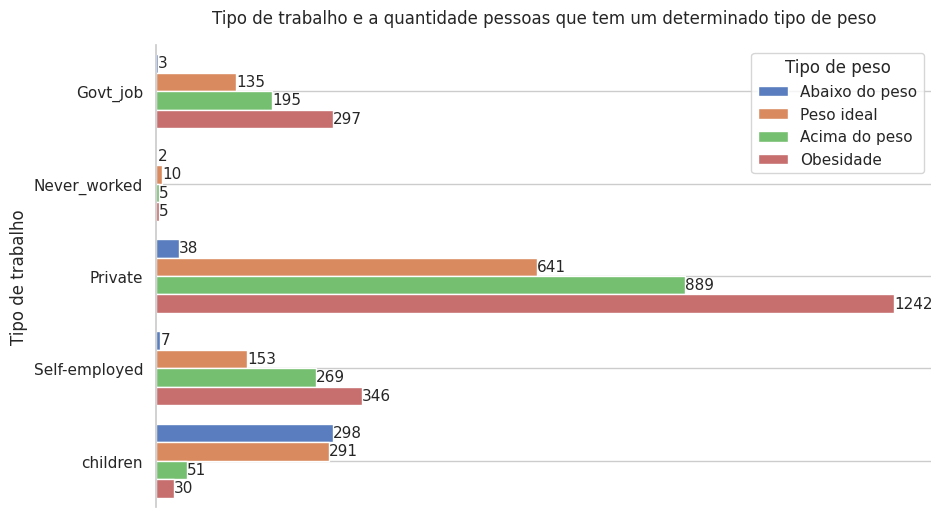

In [169]:

sea.set_theme(style="whitegrid")
fig , ax = plt.subplots(1,1)
fig.set_figwidth(10)
fig.set_figheight(6)

palette = sea.color_palette("muted",n_colors=4)
bar = sea.barplot(x=gropbyresultado['count'],y=gropbyresultado['work_type'],hue=gropbyresultado['bmi'],palette=palette,ax=ax)
for p in bar.patches:
    if p.get_width() != 0:
        bar.annotate("%.0f" % p.get_width(),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.3), textcoords= 'offset points', ha = 'left', va = "center" ,size=11)
ax.spines[['right','top','bottom']].set_visible(False)
ax.set_ylabel('Tipo de trabalho')
ax.set_xticks([])
ax.set_xlabel('')
ax.set_axisbelow(True)
ax.grid(True)
ax.set_title('Tipo de trabalho e a quantidade pessoas que tem um determinado tipo de peso',y=1.029)
ax.legend().set_title('Tipo de peso')
plt.show()

In [170]:
resultado = pd.concat([data['gender'],freq],axis=1)
resultado = resultado.groupby(by='bmi')['gender'].value_counts().reset_index()

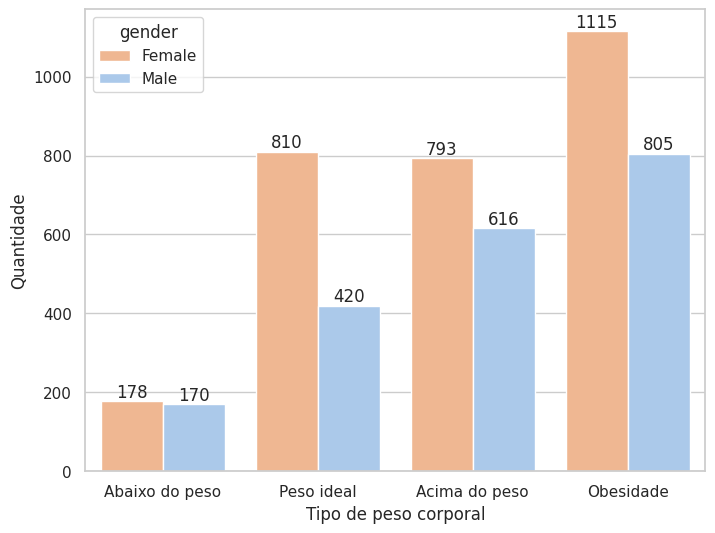

In [171]:
plt.figure(figsize=(8,6))
sea.set_theme(style='whitegrid')
bar = sea.barplot(x = resultado['bmi'],y=resultado['count'],hue=resultado['gender'],palette=sea.color_palette('pastel',n_colors=2)[::-1])
bar.bar_label(bar.containers[0])
bar.bar_label(bar.containers[1])
plt.ylabel('Quantidade')
plt.xlabel('Tipo de peso corporal')
plt.show()

<Axes: >

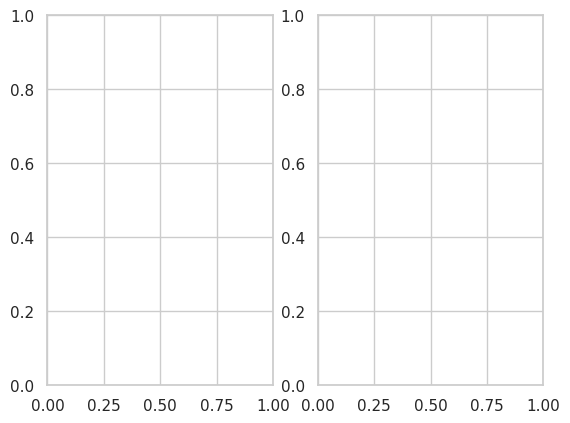

In [177]:
densidade = data[['avg_glucose_level','bmi','stroke']]

fig , ax = plt.subplots(1,2)

sea.violinplot()
sea.violinplot()


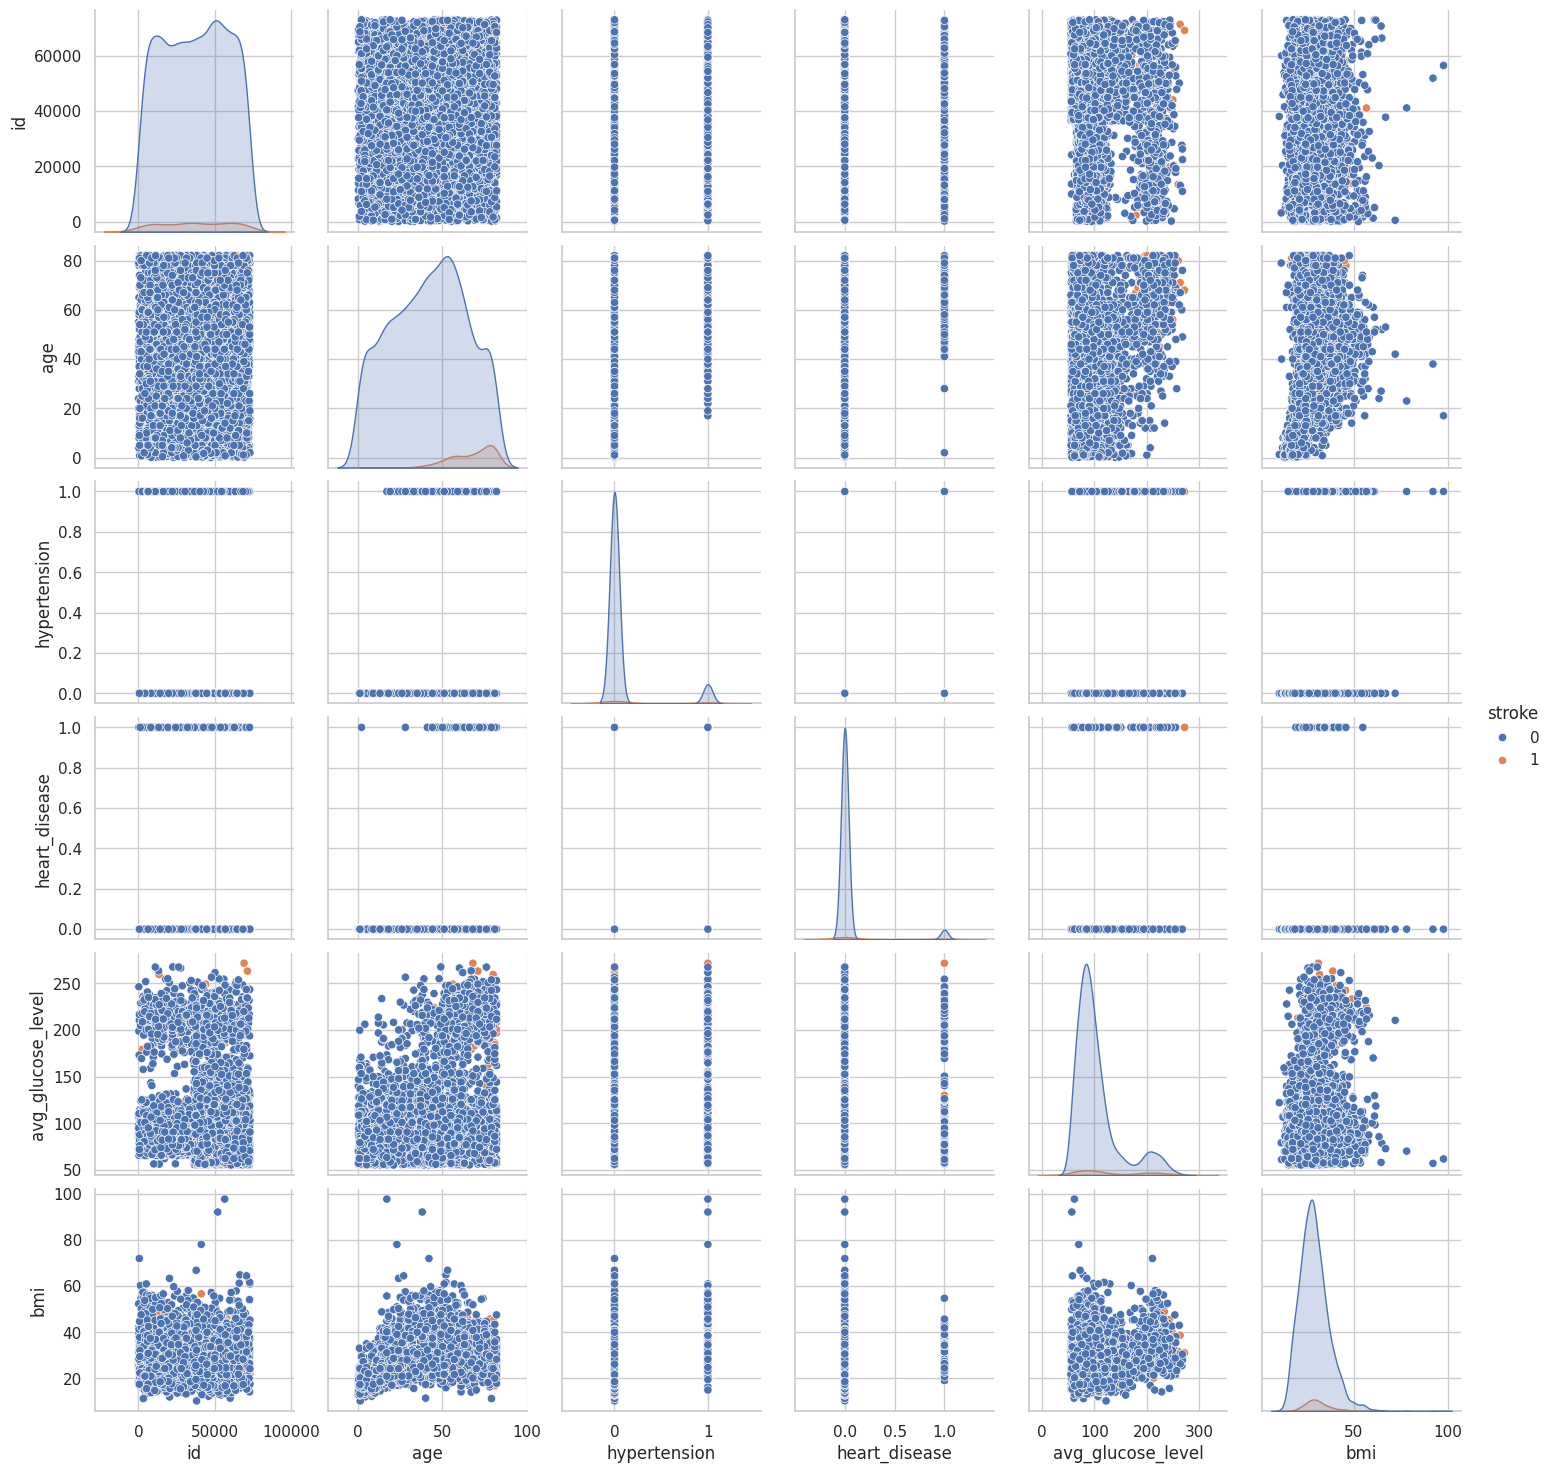

In [175]:
sea.pairplot(data,hue='stroke')
plt.show()

&nbsp;